# Data Matcher for individual Stress Profile and Flight Data

## Import Required Libraries

In [52]:
import pandas as pd
import numpy as np
from scipy import interpolate
import os
from xml.dom import minidom

from matplotlib import style
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons, RectangleSelector, RangeSlider, Cursor, SpanSelector
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import matplotlib.animation as ani

### Store SVG File Path

In [33]:
svgpathfile = "/Data/Proband_09/Sc3/VP9_S3_nml.svg"

### Importing Data 

Use minidom to parse xml content from svg file

In [34]:
xmldoc = minidom.parse(svgpathfile)

### Extract Data from SVG/XML file

#### 1st Coordinate System

get Fileheader of SVG File - it contains the view box

-> equivalent to the coordinate system for the individual stress profile

Extract X and Y max

In [77]:
fileheader = xmldoc.getElementsByTagName('svg')

viewbox = fileheader[0].attributes['viewBox'].value

viewboxElems = viewbox.split(' ')

y_max = float(viewboxElems[3])
x_max = float(viewboxElems[2])

print(f'Y Max: {y_max}')
print(f'X Max: {x_max}')

Y Max: 228.66
X Max: 710.53


#### individual Stress Profile

Stress Profile is stored in a Polyline

Search xmldoc's contenct for Elements called Polyline

Output: pointsarray

In [102]:
itemlist = xmldoc.getElementsByTagName('polyline')

pointList = itemlist[0].attributes['points'].value

pointarry = pointList.split(' ')
pointsarray = []
for points in pointarry:
    if points:
        sepPoints = points.split(',')
        pointsarray.append(list(map(float, sepPoints)))

pointsarray = np.array(pointsarray)


#### Flight Path Marker
FPM are marked as lines

Same procedure is applied to get

* Outer Marker
* Middle Marker
* Inner Marker

For Scenario 5 markers are different: 

* (Start=Outer Marker)
* Middle Marker
* Inner Marker (Go Around)
* Continous Marker 1 (ATC: Level Off 3000ft)
* Continous Marker 2 (ATC: Climb 4000ft)
* (End)

In [103]:
linelist = xmldoc.getElementsByTagName('line')

stressMarker = []

for line in linelist:
    value = line.attributes['x1'].value
    stressMarker.append(float(value))
    print(line.attributes['x1'].value)

    
print(stressMarker)

511.58
284.21
85.26
[511.58, 284.21, 85.26]


### Get AVES Flight Path Data

Next step is to get the Marker times from AVES Flight Data



In [80]:
simpathfile = "/Users/MacMaster3/Dropbox/Uni Stuttgart/Masterarbeit/Software/AVESData/Data/Proband_09/Sc3/A320ICDataRec_13Apr2022_083550_RUN5_P9S3.reca"

myFile = np.genfromtxt(simpathfile, delimiter=',', skip_header=126)

# Load System Time
sysTime = myFile[:, 0]

# normalize System Time
sysTime = np.array(sysTime)-sysTime[0]

### Seperate between Scenarios:

Scenario 5 is different than the others hence needs to be considered seperately.

**1 ft &nbsp; = &nbsp;0.3048 meter**

* Scenario 1 - 4
    - Outer Marker: &nbsp; &nbsp; @3800ft AGL = 1158.24m
    - Middel Marker: &nbsp; &nbsp; @2500ft AGL = 762m
    - Inner Marker: &nbsp; &nbsp; @1000ft AGL = 304.8m


* Scenario 5:

    - Start = Outer Marker: &nbsp; &nbsp; @3800ft AGL
    - Middel Marker: &nbsp; &nbsp; @2500ft AGL
    - Inner Marker: &nbsp; &nbsp; @ ~800ft AGL = ~243.84m
    - Continous Marker 1:  &nbsp; &nbsp; @ATC Call
    - Continous Marker 2:  &nbsp; &nbsp; @ATC Call
    - End


* Airport Stuttgart Ground Elevation
    - 1181ft = 359.97m ~ 360m 

In [104]:
outermarker = 1158.24
middlemarker = 762
innermarker = 304.8

edds_elevation = 360

### Find Marker in AVES Data Flight Path

Search AVES Data Array for positions where GPS Z (NED) is equal to marker heights


In [105]:
altitudeGPSz = myFile[:, 109]

# outer
outer_idx = (np.abs((-altitudeGPSz) - outermarker - edds_elevation)).argmin()
print(outer_idx)

om_time = round(sysTime[outer_idx],2)

print(f"OM at {om_time} s")

# middle
middle_idx = (np.abs((-altitudeGPSz) - middlemarker - edds_elevation)).argmin()
print(middle_idx)

mm_time = round(sysTime[middle_idx],2)
print(f"MM at {mm_time} s")

# inner
inner_idx = (np.abs((-altitudeGPSz) - innermarker - edds_elevation)).argmin()
print(inner_idx)
im_time = round(sysTime[inner_idx],2)
print(f"IM at {im_time} s")


10760
OM at 107.6 s
17230
MM at 172.3 s
24890
IM at 248.9 s


### Get all Stress Profil Points between Marker

Try to match the polyline points with the marker and seperate them accordingly


In [106]:
for points in pointsarray:
    if points[0]<stressMarker[2]:
        print(f"S - OM {points}")
    elif points[0]>stressMarker[2] and points[0]<stressMarker[1]:
        print(f"OM - MM {points}")
    elif points[0]>stressMarker[1] and points[0]<stressMarker[0]:
        print(f"MM - IM {points}")
    elif points[0]>stressMarker[0]:
        print(f"IM - RWY {points}")

S - OM [1.5000e-01 1.8285e+02]
S - OM [ 14.24 183.84]
S - OM [ 28.88 184.17]
S - OM [ 42.86 184.61]
S - OM [ 57.4  183.73]
S - OM [ 71.38 184.94]
OM - MM [ 85.8  183.73]
OM - MM [ 99.89 180.97]
OM - MM [114.09 179.65]
OM - MM [128.95 178.77]
OM - MM [143.05 178.88]
OM - MM [156.92 178.99]
OM - MM [171.23 178.66]
OM - MM [185.43 177.34]
OM - MM [199.74 176.79]
OM - MM [213.95 175.47]
OM - MM [227.82 173.16]
OM - MM [242.02 170.74]
OM - MM [256.66 167.43]
OM - MM [270.64 165.56]
MM - IM [285.39 161.38]
MM - IM [299.05 156.42]
MM - IM [313.47 149.82]
MM - IM [327.67 142.44]
MM - IM [341.87 133.63]
MM - IM [356.4  123.07]
MM - IM [370.5  113.82]
MM - IM [384.15 105.34]
MM - IM [398.24  96.53]
MM - IM [412.55  88.28]
MM - IM [426.97  77.05]
MM - IM [441.61  66.81]
MM - IM [456.26  58.44]
MM - IM [469.69  52.28]
MM - IM [484.    44.57]
MM - IM [498.09  38.74]
MM - IM [511.41  33.67]
IM - RWY [526.16  31.8 ]
IM - RWY [539.93  30.81]
IM - RWY [554.9   30.59]
IM - RWY [569.1   29.82]
IM - RWY [

### Applying Math

Transform the coordinate system for each marker section from SVG-Base to AVES Timebase


In [107]:
pointsarray2 = pointsarray
for points in pointsarray2:
    if points[0] < stressMarker[2]:
        
        points[1] = ((points[1]/ -y_max + 1)*10)
        
        points[0] = (points[0]/stressMarker[2])*om_time
        
        print(f"S - OM {points}")
        
    elif points[0] > stressMarker[2] and points[0] < stressMarker[1]:
        
        points[1] = ((points[1]/ -y_max + 1)*10)
        points[0] = ((points[0]-stressMarker[2])/(stressMarker[1]-stressMarker[2]))*(mm_time-om_time)+om_time
        
        print(f"OM - MM {points}")
    elif points[0] > stressMarker[1] and points[0] < stressMarker[0]:
        
        points[1] = ((points[1]/ -y_max + 1)*10)
        points[0] = ((points[0]-stressMarker[1])/(stressMarker[0]-stressMarker[1]))*(im_time-mm_time)+mm_time
        
        print(f"MM - IM {points}")
        
    elif points[0] > stressMarker[0]:
        
        points[1] = ((points[1]/ -y_max + 1)*10)
        points[0] = ((points[0]-stressMarker[0])/(x_max-stressMarker[0]))*(sysTime[-1]-im_time)+im_time
        
        print(f"IM - RWY {points}")

S - OM [0.18930331 2.00341118]
S - OM [17.97119399  1.96011546]
S - OM [36.44719681  1.94568355]
S - OM [54.09026507  1.926441  ]
S - OM [72.44006568  1.96492609]
S - OM [90.08313394  1.9120091 ]
OM - MM [107.77561196   1.96492609]
OM - MM [112.35778336   2.08562932]
OM - MM [116.97572757   2.14335695]
OM - MM [121.80830862   2.18184204]
OM - MM [126.39373209   2.1770314 ]
OM - MM [130.90435788   2.17222076]
OM - MM [135.55807489   2.18665267]
OM - MM [140.1760191   2.2443803]
OM - MM [144.82973611   2.26843348]
OM - MM [149.4509324    2.32616111]
OM - MM [153.96155818   2.42718447]
OM - MM [158.57950239   2.53301846]
OM - MM [163.34053782   2.67777486]
OM - MM [167.88693642   2.75955567]
MM - IM [172.69753705   2.94235984]
MM - IM [177.2995338    3.15927578]
MM - IM [182.15757136   3.44791393]
MM - IM [186.94149184   3.77066387]
MM - IM [191.72541232   4.15595207]
MM - IM [196.62050842   4.61777311]
MM - IM [201.37073932   5.02230386]
MM - IM [205.96936711   5.39316015]
MM - IM [210.7

### Export Data

Transformed stressprofile is exported in CSV file with

[x: simulation run time     y: perceived Stress {0,10}]

In [12]:
np.savetxt("stressprofileVP1Sc1SimTime.csv", pointsarray2, delimiter=",")

### Normalize Data

Transform Simulation Run Time to be between [{0,1}]

In [108]:
pointsarray2[:,0]=pointsarray2[:,0]-pointsarray2[0,0] #Bring Base to 0

pointsarray2[:,0]=pointsarray2[:,0]/pointsarray2[-1,0] #Scale down to length 1

print(pointsarray2)

[[0.         2.00341118]
 [0.05187771 1.96011546]
 [0.10578046 1.94568355]
 [0.15725316 1.926441  ]
 [0.21078772 1.96492609]
 [0.26226042 1.9120091 ]
 [0.31387728 1.96492609]
 [0.32724551 2.08562932]
 [0.34071812 2.14335695]
 [0.35481691 2.18184204]
 [0.36819464 2.1770314 ]
 [0.38135415 2.17222076]
 [0.39493112 2.18665267]
 [0.40840372 2.2443803 ]
 [0.42198069 2.26843348]
 [0.43546278 2.32616111]
 [0.44862229 2.42718447]
 [0.4620949  2.53301846]
 [0.47598496 2.67777486]
 [0.48924884 2.75955567]
 [0.5032835  2.94235984]
 [0.51670958 3.15927578]
 [0.53088265 3.44791393]
 [0.54483948 3.77066387]
 [0.55879631 4.15595207]
 [0.57307749 4.61777311]
 [0.58693603 5.02230386]
 [0.60035228 5.39316015]
 [0.614201   5.77844835]
 [0.62826594 6.13924604]
 [0.64243901 6.63036823]
 [0.6568283  7.0781947 ]
 [0.67122743 7.44424036]
 [0.68442744 7.71363597]
 [0.69849239 8.05081781]
 [0.71234111 8.30578151]
 [0.72543301 8.52750809]
 [0.74572763 8.6092889 ]
 [0.76473697 8.65258462]
 [0.7854029  8.6622059 ]


In [109]:
pointsarray2=np.around(pointsarray2,decimals=4)
print(pointsarray2)

[[0.     2.0034]
 [0.0519 1.9601]
 [0.1058 1.9457]
 [0.1573 1.9264]
 [0.2108 1.9649]
 [0.2623 1.912 ]
 [0.3139 1.9649]
 [0.3272 2.0856]
 [0.3407 2.1434]
 [0.3548 2.1818]
 [0.3682 2.177 ]
 [0.3814 2.1722]
 [0.3949 2.1867]
 [0.4084 2.2444]
 [0.422  2.2684]
 [0.4355 2.3262]
 [0.4486 2.4272]
 [0.4621 2.533 ]
 [0.476  2.6778]
 [0.4892 2.7596]
 [0.5033 2.9424]
 [0.5167 3.1593]
 [0.5309 3.4479]
 [0.5448 3.7707]
 [0.5588 4.156 ]
 [0.5731 4.6178]
 [0.5869 5.0223]
 [0.6004 5.3932]
 [0.6142 5.7784]
 [0.6283 6.1392]
 [0.6424 6.6304]
 [0.6568 7.0782]
 [0.6712 7.4442]
 [0.6844 7.7136]
 [0.6985 8.0508]
 [0.7123 8.3058]
 [0.7254 8.5275]
 [0.7457 8.6093]
 [0.7647 8.6526]
 [0.7854 8.6622]
 [0.805  8.6959]
 [0.8238 8.7199]
 [0.8444 8.7632]
 [0.8631 8.744 ]
 [0.8821 8.744 ]
 [0.9017 8.7392]
 [0.9223 8.821 ]
 [0.9416 8.8787]
 [0.9609 8.9032]
 [0.9805 8.9128]
 [1.     8.845 ]]


In [110]:
piRunTime = 319

pointsarray2[:,0]=pointsarray2[:,0]*piRunTime
print(pointsarray2)

[[  0.       2.0034]
 [ 16.5561   1.9601]
 [ 33.7502   1.9457]
 [ 50.1787   1.9264]
 [ 67.2452   1.9649]
 [ 83.6737   1.912 ]
 [100.1341   1.9649]
 [104.3768   2.0856]
 [108.6833   2.1434]
 [113.1812   2.1818]
 [117.4558   2.177 ]
 [121.6666   2.1722]
 [125.9731   2.1867]
 [130.2796   2.2444]
 [134.618    2.2684]
 [138.9245   2.3262]
 [143.1034   2.4272]
 [147.4099   2.533 ]
 [151.844    2.6778]
 [156.0548   2.7596]
 [160.5527   2.9424]
 [164.8273   3.1593]
 [169.3571   3.4479]
 [173.7912   3.7707]
 [178.2572   4.156 ]
 [182.8189   4.6178]
 [187.2211   5.0223]
 [191.5276   5.3932]
 [195.9298   5.7784]
 [200.4277   6.1392]
 [204.9256   6.6304]
 [209.5192   7.0782]
 [214.1128   7.4442]
 [218.3236   7.7136]
 [222.8215   8.0508]
 [227.2237   8.3058]
 [231.4026   8.5275]
 [237.8783   8.6093]
 [243.9393   8.6526]
 [250.5426   8.6622]
 [256.795    8.6959]
 [262.7922   8.7199]
 [269.3636   8.7632]
 [275.3289   8.744 ]
 [281.3899   8.744 ]
 [287.6423   8.7392]
 [294.2137   8.821 ]
 [300.3704   

In [113]:
piRunTime = 319
piFs=300
stressPiTimes = np.linspace(0,piRunTime,piRunTime*piFs)

print(stressPiTimes)

[0.00000000e+00 3.33336816e-03 6.66673633e-03 ... 3.18993333e+02
 3.18996667e+02 3.19000000e+02]


In [111]:
f = interpolate.interp1d(pointsarray2[:,0],pointsarray2[:,1])

In [115]:
y_new = f(stressPiTimes)
print(y_new)

[2.0034     2.00339128 2.00338256 ... 8.84507266 8.84503633 8.845     ]


In [117]:
print(y_new.size)
print(stressPiTimes.size)

95700
95700


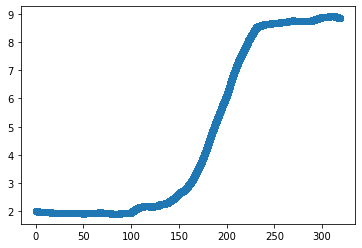

In [118]:
plt.plot(stressPiTimes, y_new, 'o')